In [37]:
import pandas as pd
import pandas_ta as ta
import yfinance as yf
from fastai.tabular.all import add_datepart
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,KFold
from sklearn.metrics import mean_absolute_error

In [38]:
df = pd.DataFrame()
df = df.ta.ticker('NVDA', period = '4y', interval = "1d")

df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-01,70.467006,72.426074,70.080152,71.756516,62206000,0.0,0.0
2018-10-02,71.481248,72.599656,70.819129,71.042320,38396400,0.0,0.0
2018-10-03,71.746616,71.821008,70.062805,71.104340,32055200,0.0,0.0
2018-10-04,70.742260,70.985286,68.488090,69.259323,39122000,0.0,0.0
2018-10-05,69.011352,69.633786,66.345529,66.920845,42663600,0.0,0.0
...,...,...,...,...,...,...,...
2022-09-26,124.910004,126.589996,122.139999,122.279999,54734300,0.0,0.0
2022-09-27,125.070000,127.360001,122.580002,124.129997,55385400,0.0,0.0
2022-09-28,124.099998,128.229996,123.540001,127.360001,54241400,0.0,0.0


In [39]:
CustomStrategy = ta.Strategy(
    name="Momo and Volatility",
    description="SMA 4,50, BBANDS, RSI, MACD and Volume SMA 20",
    ta=[
        {"kind": "sma", "length": 50},
        {"kind": "sma", "length": 4},
        {"kind": "bbands", "length": 20},
        {"kind": "rsi"},
        {"kind": "macd", "fast": 8, "slow": 21},
        {"kind": "sma", "close": "volume", "length": 20, "prefix": "VOLUME"},
    ]
)
# To run your "Custom Strategy". Adds columns to df.
df.ta.strategy(CustomStrategy)


In [40]:
df['Actual Returns'] = df['Close'].pct_change()

In [41]:
df[['Close','SMA_50','SMA_4','BBL_20_2.0','BBM_20_2.0','BBU_20_2.0','BBB_20_2.0','BBP_20_2.0','RSI_14','MACD_8_21_9','MACDh_8_21_9','MACDs_8_21_9','VOLUME_SMA_20']]=df[['Close','SMA_50','SMA_4','BBL_20_2.0','BBM_20_2.0','BBU_20_2.0','BBB_20_2.0','BBP_20_2.0','RSI_14','MACD_8_21_9','MACDh_8_21_9','MACDs_8_21_9','VOLUME_SMA_20']].shift(-1)

In [42]:
df['Signal'] = 0.0
# Generate signal to buy stock long
df.loc[(df['Actual Returns'] >= 0), 'Signal'] = 1
# Generate signal to sell stock short
df.loc[(df['Actual Returns'] < 0), 'Signal'] = 0



In [43]:
df.reset_index(inplace=True)

In [44]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_50,SMA_4,...,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_20,Actual Returns,Signal
0,2018-10-01,70.467006,72.426074,70.080152,71.042320,62206000,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2018-10-02,71.481248,72.599656,70.819129,71.104340,38396400,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009953,0.0
2,2018-10-03,71.746616,71.821008,70.062805,69.259323,32055200,0.0,0.0,NaN,70.790625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000873,1.0
3,2018-10-04,70.742260,70.985286,68.488090,66.920845,39122000,0.0,0.0,NaN,69.581707,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.025948,0.0
4,2018-10-05,69.011352,69.633786,66.345529,65.906578,42663600,0.0,0.0,NaN,68.297771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.033764,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2022-09-26,124.910004,126.589996,122.139999,124.129997,54734300,0.0,0.0,161.116321,124.295000,...,151.900894,24.947779,0.175768,31.451760,-10.095179,0.456025,-10.551203,62954290.0,-0.023011,0.0
1004,2022-09-27,125.070000,127.360001,122.580002,127.360001,55385400,0.0,0.0,160.266131,124.732500,...,148.234893,21.758039,0.282365,35.778572,-9.235908,1.052236,-10.288144,63015455.0,0.015129,1.0
1005,2022-09-28,124.099998,128.229996,123.540001,122.199997,54241400,0.0,0.0,159.149789,123.992498,...,145.313800,19.746413,0.114949,32.273846,-9.119336,0.935047,-10.054382,62810720.0,0.026021,1.0
1006,2022-09-29,124.480003,125.000000,119.459999,121.389999,53276300,0.0,0.0,157.968661,123.769999,...,144.808869,20.478079,0.129403,31.748110,-8.959045,0.876270,-9.835315,59740740.0,-0.040515,0.0


In [45]:
add_datepart(df, 'Date', drop=False)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_50,SMA_4,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2018-10-01,70.467006,72.426074,70.080152,71.042320,62206000,0.0,0.0,NaN,NaN,...,1,0,274,False,True,False,True,False,False,1.538352e+09
1,2018-10-02,71.481248,72.599656,70.819129,71.104340,38396400,0.0,0.0,NaN,NaN,...,2,1,275,False,False,False,False,False,False,1.538438e+09
2,2018-10-03,71.746616,71.821008,70.062805,69.259323,32055200,0.0,0.0,NaN,70.790625,...,3,2,276,False,False,False,False,False,False,1.538525e+09
3,2018-10-04,70.742260,70.985286,68.488090,66.920845,39122000,0.0,0.0,NaN,69.581707,...,4,3,277,False,False,False,False,False,False,1.538611e+09
4,2018-10-05,69.011352,69.633786,66.345529,65.906578,42663600,0.0,0.0,NaN,68.297771,...,5,4,278,False,False,False,False,False,False,1.538698e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2022-09-26,124.910004,126.589996,122.139999,124.129997,54734300,0.0,0.0,161.116321,124.295000,...,26,0,269,False,False,False,False,False,False,1.664150e+09
1004,2022-09-27,125.070000,127.360001,122.580002,127.360001,55385400,0.0,0.0,160.266131,124.732500,...,27,1,270,False,False,False,False,False,False,1.664237e+09
1005,2022-09-28,124.099998,128.229996,123.540001,122.199997,54241400,0.0,0.0,159.149789,123.992498,...,28,2,271,False,False,False,False,False,False,1.664323e+09
1006,2022-09-29,124.480003,125.000000,119.459999,121.389999,53276300,0.0,0.0,157.968661,123.769999,...,29,3,272,False,False,False,False,False,False,1.664410e+09


In [46]:
df.drop(columns=['Dividends', 'Stock Splits', 'Open', 'High', 'Low', 'Year'],inplace=True,axis=1)

In [47]:
df=df.iloc[51:]
df=df.iloc[:-1]
df

,Date,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
51,2018-12-13,36.353531,47138400,48.815061,36.764977,32.302109,38.648100,44.994091,32.839860,0.319211,...,13,3,347,False,False,False,False,False,False,1.544659e+09
52,2018-12-14,35.641102,47182000,48.142696,36.478888,34.270590,37.920685,41.570781,19.251210,0.187736,...,14,4,348,False,False,False,False,False,False,1.544746e+09
53,2018-12-17,36.475170,66286800,47.533783,36.357256,34.252293,37.705648,41.159002,18.317438,0.321843,...,17,0,351,False,False,False,False,False,False,1.545005e+09
54,2018-12-18,34.382565,56437200,46.903303,35.713092,33.963536,37.630615,41.297693,19.489868,0.057134,...,18,1,352,False,False,False,False,False,False,1.545091e+09
55,2018-12-19,33.536098,74536400,46.257033,35.008734,33.385235,37.458951,41.532666,21.750292,0.018517,...,19,2,353,False,False,False,False,False,False,1.545178e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,2022-09-23,122.279999,66184000,161.852964,126.415001,117.945691,136.746015,155.546339,27.496705,0.115272,...,23,4,266,False,False,False,False,False,False,1.663891e+09
1003,2022-09-26,124.129997,54734300,161.116321,124.295000,118.207830,135.054362,151.900894,24.947779,0.175768,...,26,0,269,False,False,False,False,False,False,1.664150e+09
1004,2022-09-27,127.360001,55385400,160.266131,124.732500,119.146427,133.690660,148.234893,21.758039,0.282365,...,27,1,270,False,False,False,False,False,False,1.664237e+09
1005,2022-09-28,122.199997,54241400,159.149789,123.992498,119.198003,132.255902,145.313800,19.746413,0.114949,...,28,2,271,False,False,False,False,False,False,1.664323e+09


In [48]:
df=df.set_index(['Date'])

In [49]:
# from pathlib import Path
# df.to_csv(Path("./Resources/testframe.csv"))

In [50]:
# # Splitting the dataset into 70% training, 15% validation and 15% test
# # train test split indexes


# test_size  = 0.15
# valid_size = 0.15

# test_split_idx  = int(df.shape[0] * (1-test_size))
# valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))


# #train test split tcs

# train= df.iloc[:valid_split_idx]
# valid= df.iloc[valid_split_idx+1:test_split_idx]
# test= df.iloc[test_split_idx+1:]

In [51]:
# y_train = train['Close']
# X_train = train.drop(['Close','Actual Returns'], 1)

# y_valid = valid['Close']
# X_valid = valid.drop(['Close','Actual Returns'], 1)

# y_test = test['Close']
# X_test = test.drop(['Close','Actual Returns'], 1)

In [52]:
# parameters = {
#     'n_estimators': [500,600],
#     'learning_rate': [0.1],
#     'max_depth': [8, 12, 15],
#     'gamma': [ 0.005, 0.01,],
#     'random_state': [42],
#     'min_child_weight':[4,3],
#     'subsample':[0.8,1],
#     'colsample_bytree':[1],
#     'colsample_bylevel':[1]
# }
# kfold=KFold(5)
# eval_set = [(X_train, y_train), (X_valid, y_valid)]
# model = xgb.XGBRegressor(objective='reg:squarederror',n_jobs=-1)
# clf = GridSearchCV(model, parameters,cv=kfold,scoring='neg_mean_absolute_error',verbose=0)

# clf.fit(X_train, y_train)

# print(f'Best params: {clf.best_params_}')
# print(f'Best validation score = {clf.best_score_}')

In [53]:
# model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror',n_jobs=-1)
# model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
# y_pred=model.predict(X_test)
# mean_absolute_error(y_test,y_pred)

In [54]:
# xgb.plot_importance(model)

In [55]:
# # Create a new empty predictions DataFrame using code provided below.
# predictions_df = pd.DataFrame(index=X_test.index)
# predictions_df['Predicted Returns'] = y_pred
# predictions_df['Predicted Returns'].value_counts()

# # Add in actual returns and calculate trading returns
# predictions_df['Actual Returns'] = df['Actual Returns']
# predictions_df['Close'] = df['Close']
# predictions_df['Algo Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted Returns']
# predictions_df.tail(20)



In [56]:

# # Calculate and plot the cumulative returns for the `Actual Returns` and the `Algo Returns`
# (1 + predictions_df[['Actual Returns', 'Algo Returns']]).cumprod().plot()

In [57]:
X = df.drop(columns=['Actual Returns', 'Signal'])
X

,Close,Volume,SMA_50,SMA_4,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-13,36.353531,47138400,48.815061,36.764977,32.302109,38.648100,44.994091,32.839860,0.319211,34.813173,...,13,3,347,False,False,False,False,False,False,1.544659e+09
2018-12-14,35.641102,47182000,48.142696,36.478888,34.270590,37.920685,41.570781,19.251210,0.187736,33.519161,...,14,4,348,False,False,False,False,False,False,1.544746e+09
2018-12-17,36.475170,66286800,47.533783,36.357256,34.252293,37.705648,41.159002,18.317438,0.321843,36.495247,...,17,0,351,False,False,False,False,False,False,1.545005e+09
2018-12-18,34.382565,56437200,46.903303,35.713092,33.963536,37.630615,41.297693,19.489868,0.057134,32.557317,...,18,1,352,False,False,False,False,False,False,1.545091e+09
2018-12-19,33.536098,74536400,46.257033,35.008734,33.385235,37.458951,41.532666,21.750292,0.018517,31.095683,...,19,2,353,False,False,False,False,False,False,1.545178e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-23,122.279999,66184000,161.852964,126.415001,117.945691,136.746015,155.546339,27.496705,0.115272,28.904254,...,23,4,266,False,False,False,False,False,False,1.663891e+09
2022-09-26,124.129997,54734300,161.116321,124.295000,118.207830,135.054362,151.900894,24.947779,0.175768,31.451760,...,26,0,269,False,False,False,False,False,False,1.664150e+09
2022-09-27,127.360001,55385400,160.266131,124.732500,119.146427,133.690660,148.234893,21.758039,0.282365,35.778572,...,27,1,270,False,False,False,False,False,False,1.664237e+09


In [58]:
y = df['Signal']

y


Date
2018-12-13    0.0
2018-12-14    0.0
2018-12-17    0.0
2018-12-18    1.0
2018-12-19    0.0
             ... 
2022-09-23    0.0
2022-09-26    0.0
2022-09-27    1.0
2022-09-28    1.0
2022-09-29    0.0
Name: Signal, Length: 956, dtype: float64

In [59]:
training_begin = X.index.min() + DateOffset(months=14)
print(training_begin)

2020-02-13 00:00:00


In [60]:
training_end = X.index.max() - DateOffset(months=5)
print(training_end) 

2022-04-29 00:00:00


In [61]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

In [62]:
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

In [63]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [64]:
#Use RandomOverSampler to resample the datase using random_state=1
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)

In [65]:
model = xgb.XGBClassifier()

In [66]:
model = model.fit(X_resampled, y_resampled)

In [67]:
training_signal_predictions = model.predict(X_resampled)

In [68]:
training_report = classification_report(y_resampled, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       302
         1.0       1.00      1.00      1.00       302

    accuracy                           1.00       604
   macro avg       1.00      1.00      1.00       604
weighted avg       1.00      1.00      1.00       604



In [69]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)

# Evaluate the model's ability to predict the trading signal for the testing data using a classification report
training_report = classification_report(y_test, testing_signal_predictions)

print(training_report)


              precision    recall  f1-score   support

         0.0       0.58      0.70      0.64        54
         1.0       0.61      0.48      0.54        52

    accuracy                           0.59       106
   macro avg       0.60      0.59      0.59       106
weighted avg       0.60      0.59      0.59       106



In [70]:
# Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['Predicted Returns'] = testing_signal_predictions
predictions_df['Predicted Returns'].value_counts()

# Add in actual returns and calculate trading returns
predictions_df['Actual Returns'] = df['Actual Returns']
predictions_df['Algo Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted Returns']
predictions_df.tail(20)


,Predicted Returns,Actual Returns,Algo Returns
Date,,,
2022-09-01,0,-0.076653,-0.000000
2022-09-02,1,-0.020808,-0.020808
2022-09-06,0,-0.013336,-0.000000
2022-09-07,0,0.018795,0.000000
2022-09-08,0,0.020125,0.000000
2022-09-09,0,0.028377,0.000000
2022-09-12,0,0.008202,0.000000
2022-09-13,0,-0.094726,-0.000000
2022-09-14,0,-0.000228,-0.000000


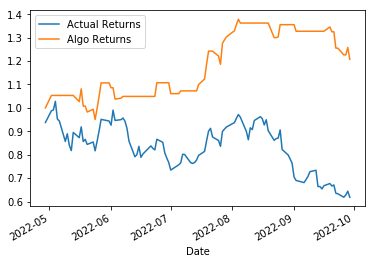

In [71]:
# Calculate and plot the cumulative returns for the `Actual Returns` and the `Algo Returns`
(1 + predictions_df[['Actual Returns', 'Algo Returns']]).cumprod().plot()